In [1]:
import numpy as np
import datetime
import requests
import matplotlib.pyplot as plt
import cv2
import networkx as nx
from sklearn.cluster import KMeans

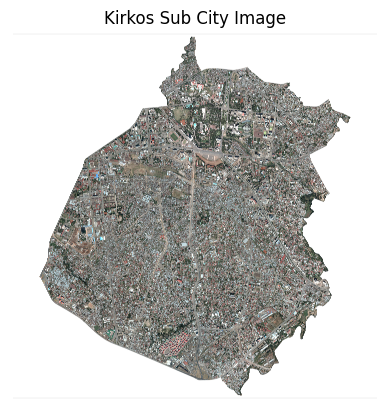

In [2]:
# Save the image to a file
image_path = 'B:\Msc Courses\First year\Second semister\Probabilistic Graphical Models\HW3\Kirkos.jpg'

# Load and display the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title("Kirkos Sub City Image")
plt.axis('off')
plt.show()


In [3]:
# Define the center coordinates and radius (in meters)
latitude= 9.005401   # (Addis Ababa)
longitude= 38.763611  # (Addis Ababa)
radius = 1000 / 3.281  # Convert 1000 feet to meters

# Step 2: Create the request URL
api_url = f"https://api.open-elevation.com/api/v1/lookup?locations={latitude},{longitude}"

# Step 3: Make the request to the Open Elevation API
response = requests.get(api_url)

# Step 4: Parse the response
if response.status_code == 200:
    data = response.json()
    if 'results' in data and len(data['results']) > 0:
        elevation = data['results'][0]['elevation']
        print(f"The elevation at latitude {latitude}, longitude {longitude} is {elevation} meters.")
    else:
        print("No elevation data found for the specified location.")
else:
    print(f"Failed to retrieve elevation data. HTTP status code: {response.status_code}")


The elevation at latitude 9.005401, longitude 38.763611 is 2355.0 meters.


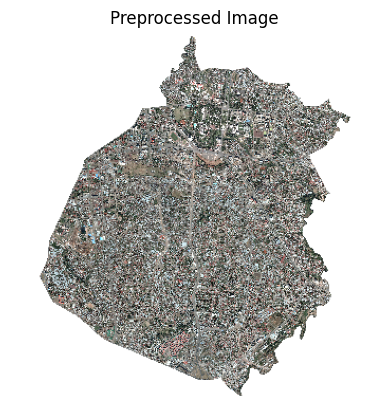

In [4]:
#Preprocess the Image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Resize the image to 350x350 pixels
image_resized = cv2.resize(image, (350, 350))
center = (175, 175)  # Center pixel in a 350x350 image

# Display the preprocessed image
plt.imshow(image_resized)
plt.title("Preprocessed Image")
plt.axis('off')
plt.show()

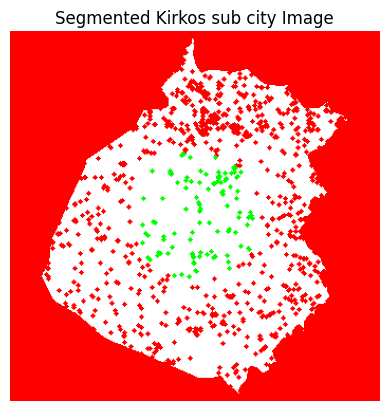

In [5]:
# Flatten the image for clustering
pixels = image_resized.reshape(-1, 3)

# Apply k-means clustering with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=0).fit(pixels)
labels = kmeans.labels_
clustered_image = labels.reshape(350, 350)

# Define the graphical model
graph = nx.grid_2d_graph(350, 350)

# Assign cluster labels to nodes
for i in range(350):
    for j in range(350):
        graph.nodes[(i, j)]['label'] = clustered_image[i, j]

# Define potential functions based on cluster labels
def potential_function(node1_label, node2_label):
    return 1 if node1_label == node2_label else 0

# Initialize messages
messages = {(edge[0], edge[1]): 1.0 for edge in graph.edges}
messages.update({(edge[1], edge[0]): 1.0 for edge in graph.edges})

# Assign potential values to edges
for edge in graph.edges:
    node1, node2 = edge
    node1_label = graph.nodes[node1]['label']
    node2_label = graph.nodes[node2]['label']
    graph.edges[edge]['potential'] = potential_function(node1_label, node2_label)

# Belief propagation
def belief_propagation(graph, max_iterations=10):
    for _ in range(max_iterations):
        new_messages = messages.copy()
        for edge in graph.edges:
            node1, node2 = edge
            potential = graph.edges[edge]['potential']
            new_messages[(node1, node2)] = np.exp(-potential) * np.prod(
                [messages[(neighbor, node1)] for neighbor in graph.neighbors(node1) if neighbor != node2]
            )
            new_messages[(node2, node1)] = np.exp(-potential) * np.prod(
                [messages[(neighbor, node2)] for neighbor in graph.neighbors(node2) if neighbor != node1]
            )
        messages.update(new_messages)
    
    beliefs = {}
    for node in graph.nodes:
        beliefs[node] = np.prod([messages[(neighbor, node)] for neighbor in graph.neighbors(node)])
    
    return beliefs

beliefs = belief_propagation(graph)

# Segment the image based on beliefs
segmented_image = np.zeros((350, 350, 3), dtype=np.uint8)
threshold = 0.5  # Example threshold for segmentation

# Assign colors to different clusters for visualization
cluster_colors = {
    0: [255, 0, 0],  # Red
    1: [0, 255, 0],  # Green
    2: [0, 0, 255],  # Blue
    3: [255, 255, 0],  # Yellow
    4: [0, 255, 255]   # Cyan
}

for node in graph.nodes:
    cluster_label = graph.nodes[node]['label']
    if beliefs[node] > threshold:
        segmented_image[node] = cluster_colors[cluster_label]
    else:
        segmented_image[node] = image_resized[node]

# Draw edges from the specified location to clusters of trees
tree_nodes = [node for node in graph.nodes if segmented_image[node][1] == 255]

for node in tree_nodes:
    cv2.line(segmented_image, center, tuple(node[::-1]), (255, 255, 255), 2)  # White lines

# Draw color-coded boundaries around detected regions
center_coords = np.array(center)
for node in tree_nodes:
    distance = np.linalg.norm(np.array(node) - center_coords)
    if distance <= 200 / 3.281:
        cv2.circle(segmented_image, tuple(node[::-1]), 2, (0, 255, 0), -1)  # Green for within 200 ft
    elif 200 / 3.281 < distance <= 1000 / 3.281:
        cv2.circle(segmented_image, tuple(node[::-1]), 2, (255, 0, 0), -1)  # Red for between 200 ft and 1000 ft

# Display the segmented image
plt.imshow(segmented_image)
plt.title("Segmented Kirkos sub city Image")
plt.axis('off')
plt.show()


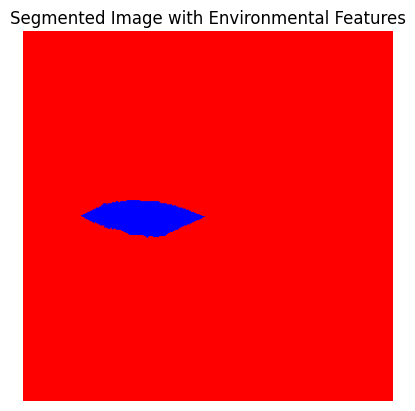

In [9]:
# Draw edges from the specified location to clusters of trees
tree_nodes = [node for node in graph.nodes if segmented_image[node][1] == 255]

for node in tree_nodes:
    cv2.line(segmented_image, center, node, (0, 255, 255), 1)  # Yellow lines

# Draw color-coded boundaries around detected regions
center_coords = np.array(center)
for node in tree_nodes:
    distance = np.linalg.norm(np.array(node) - center_coords)
    if distance <= 200 / 3.281:
        cv2.circle(segmented_image, node, int(200 / 3.281), (0, 0, 255), 2)  # Draw a blue circle within 200 ft radius
    elif 200 / 3.281 < distance <= 1000 / 3.281:
        cv2.circle(segmented_image, node, int(distance), (255, 0, 0), 2)  # Draw a red circle between 200 ft and 1000 ft radiu

# Display the segmented image
plt.imshow(segmented_image)
plt.title("Segmented Kirkos sub city Image with Environmental Features")
plt.axis('off')
plt.show()
